# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import warnings
from collections import Counter
from utils.textnormalization import text_normalization
from utils.machinelearning import machine_learning_model, fit_model
from utils.deeplearning import model_compile, model_fit, lstm_, gru_, bidirectional_lstm
from utils.plot_model_changes import plot_changes
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import bar_plot
from utils.deeplearning_preprcosesing import  deeplearning_preprcosesing_
from utils.word_vector import word_vector_
from utils.confusion_matrix import confusion_matrix_, confusion_matrix_display
from utils.generate_poitive_negative import generate_poitive_negative
from utils.performance_metrics import accuracy_score, precision_score, sensitivity_score, specificity_score, f1_score, error_rate, performance_metrics_data_frame
from utils.model_inference import machine_learning_inference, deep_learning_inference
from utils.transformers_ import sentiment_analysis_transformers
from utils.word_2_vec import word_2_vec_
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# Download Some Packages

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

In [4]:
Corpus = pd.read_csv('Balanced Review.csv')
sentiment = []
for i in Corpus['rating']:
    if i == 1 or i == 2:
        sentiment.append('Negative')
    else:
        sentiment.append('Positive')
Corpus['Sentiment'] = sentiment
Corpus.rename(columns={'review': 'Review'}, inplace=True)
Corpus = Corpus[['Review', 'Sentiment']]
Corpus['Review'] = Corpus['Review'].astype(str)
Corpus = Corpus.sample(frac=1, random_state=44, ignore_index=True)
Corpus.index = Corpus.index + 1 

Corpus

Review Sentiment
1                 جيد. . الانترنت سلكي فقط وبطيئ جداااااا  Positive
2                      “الهجة”. لاشي. ممنوع دخول الضيوف !  Negative
3       “انصح به”. نظافة الغرف والخدمه المميزه وموقع ا...  Positive
4       “رائع”. كل شي حلو وجميل الافطار متنوع. لايوجد ...  Negative
5       “جيد لكن المطعم سئ”. المعاملة الجيدة. المطعم ب...  Positive
...                                                   ...       ...
105350  “المكان خيال”. المكان حده خيال وهدوء وكل شي حلو.   Positive
105351  “لان اكرر الزياره للفندق للاسف”. الموقع ممتاز ...  Negative
105352  “من اسوى الفنادق ع الاطلاق”. لا شي سو ديكور ال...  Negative
105353  “لا انصح بهذا الفندق”. استقبال موظفي الاستقبال...  Negative
105354  “اتلانتس متعه لاتقاوم”. اعجبني كل شي في الفندق...  Positive

[105354 rows x 2 columns]

# Validation Data

In [5]:
reviews = ["لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.",
       "الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.",
        "كانت الأسرة في الغرفة مريحة جدًا.",
        "الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.",
        "كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.",
        "الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.",
        "الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.",
        "الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.",
        "استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.",
        "المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إلى تجديدات عاجلة.",]

# Word To Vector Data

In [6]:
Data = pd.read_csv('Arabic Data.txt', header=None, sep = "\t", on_bad_lines='skip', encoding='utf-8', encoding_errors='ignore',  skiprows=[2564821])

# Sentiment Information

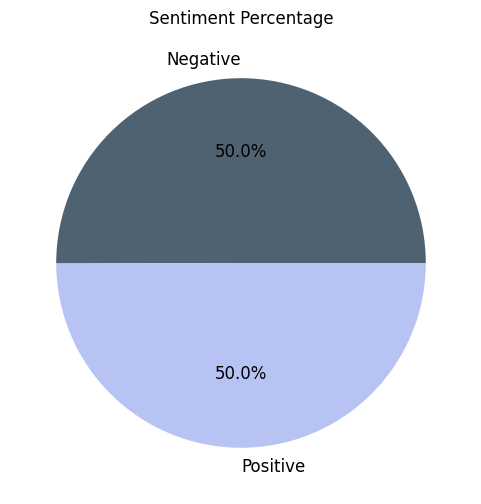

In [7]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

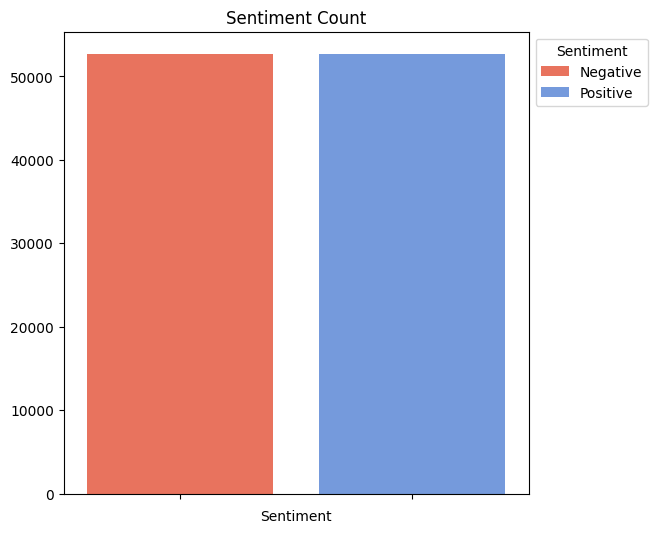

In [8]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [9]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

315476

# Average Number Of Sentences

In [10]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [11]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

93

# Minimum Number Of Sentences

In [12]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Number Of Words Before Review Normalization

In [13]:
Corpus["Number of Words 1"] = Corpus["Review"].apply(lambda n:len(word_tokenize(n)))
Corpus["Number of Words 1"].sum()

2882393

# Average Number Of Words Before Review Normalization

In [14]:
AverageNaumberOfWords1 = int(np.round((Corpus["Number of Words 1"].mean())))
AverageNaumberOfWords1

27

# Maximum Number Of Word Before Review Normalization

In [15]:
MaximumNaumberOfWords1 = Corpus["Number of Words 1"].max()
MaximumNaumberOfWords1

623

# Minimum Number Of Words Before Review Normalization

In [16]:
MimimumNaumberOfWords1 = Corpus["Number of Words 1"].min()
MimimumNaumberOfWords1

4

# Number Of Charachters Before Review Normalization

In [17]:
Corpus["Number of Charachters 1"] = Corpus["Review"].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 1"].sum()

11441888

# Average Number Of Charachters Before Review Normalization

In [18]:
AverageNumberOfCharachters1 = int(np.round(Corpus["Number of Charachters 1"].mean()))
AverageNumberOfCharachters1

109

# Maximum Number Of Charachters Before Review Normalization

In [19]:
MaximumNumberOfCharachters1 = Corpus['Number of Charachters 1'].max() 
MaximumNumberOfCharachters1

2705

# Minimum Number Of Charachters Before Review Normalization

In [20]:
MinimumNumberOfCharachters1 = Corpus['Number of Charachters 1'].min() 
MinimumNumberOfCharachters1

0

In [21]:
Corpus[Corpus['Number of Charachters 1'] == 0]

Review Sentiment  NumberOfSentences  Number of Words 1  \
29816       “9. .   Positive                  2                  4   
43299  “4 😑”. . 4😑  Negative                  3                  7   
61730    “*”. *. *  Negative                  3                  7   
93715   “❤️”. 👍. 👆  Positive                  3                  7   

       Number of Charachters 1  
29816                        0  
43299                        0  
61730                        0  
93715                        0

# Most Frequent Words Before Review Normalization

In [22]:
MostFrequentWord1 = Counter((Corpus['Review']).str.split().explode()).most_common(15)
MostFrequentWordDF1 = pd.DataFrame(MostFrequentWord1, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF1

Word  Count
1          من  50444
2          في  48500
3      الفندق  33222
4          لا  27498
5           .  26391
6         جدا  25645
7           و  21830
8         غير  18135
9          كل  17053
10        على  15771
11  الاستقبال  15168
12      الغرف  14295
13         شي  13539
14         لم  13296
15       يوجد  11828

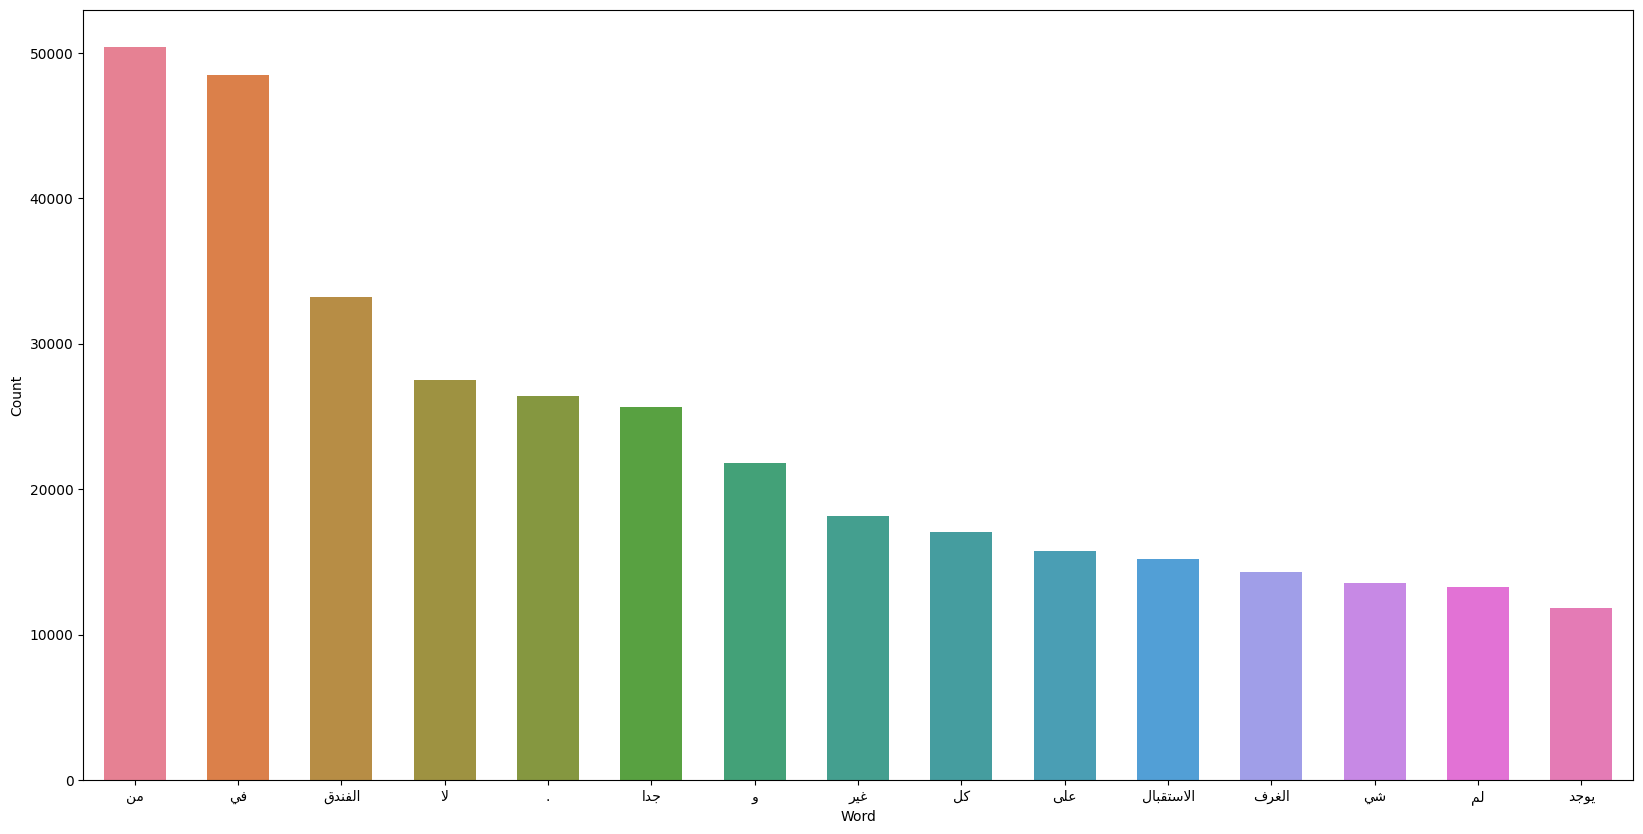

In [23]:
bar_plot(data=MostFrequentWordDF1, text = 'Word', x = 'Word', y='Count')

# Review Normalization

In [24]:
Corpus['Normalized_Review'] = Corpus['Review'].map(text_normalization)
Corpus.dropna(axis=1, inplace=True)
Corpus[['Normalized_Review', 'Sentiment']].to_csv('Normalized Corpus.csv', index=None)
Corpus.tail()

Review Sentiment  \
105350  “المكان خيال”. المكان حده خيال وهدوء وكل شي حلو.   Positive   
105351  “لان اكرر الزياره للفندق للاسف”. الموقع ممتاز ...  Negative   
105352  “من اسوى الفنادق ع الاطلاق”. لا شي سو ديكور ال...  Negative   
105353  “لا انصح بهذا الفندق”. استقبال موظفي الاستقبال...  Negative   
105354  “اتلانتس متعه لاتقاوم”. اعجبني كل شي في الفندق...  Positive   

        NumberOfSentences  Number of Words 1  Number of Charachters 1  \
105350                  2                 13                       36   
105351                  3                 32                      151   
105352                  3                 55                      207   
105353                  3                 29                      132   
105354                  3                 18                       63   

                                        Normalized_Review  
105350       المكان خيال المكان حده خيال وهدوء وكل شي حلو  
105351  اكرر الزياره للفندق للاسف الموقع ممتاز الاستقب...  
105352  اسوى الفنادق الاطلاق شي سو ديكور الوبي الفندق ...  
105353  انصح الفندق استقبال موظفي الاستقبال والعمال مق...  
105354  اتلانتس متعه لاتقاوم اعجبني شي الفندق وسوف اكر...

# Number Of Unique Words

In [25]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)
len(UniqueWords)

119764

# Number Of Words After Review Normalization

In [26]:
Corpus["Number of Words 2"] = Corpus["Normalized_Review"].apply(lambda n:len(word_tokenize(n)))
Corpus["Number of Words 2"].sum()

1800464

# Average Number Of Words After Review Normalization

In [27]:
AverageNaumberOfWords2 = int(np.round((Corpus["Number of Words 2"].mean())))
AverageNaumberOfWords2

17

# Maximum Number Of Word After Review Normalization

In [28]:
MaximumNaumberOfWords2 = Corpus["Number of Words 2"].max()
MaximumNaumberOfWords2

391

# Minimum Number Of Words After Review Normalization

In [29]:
MimimumNaumberOfWords2 = Corpus["Number of Words 2"].min()
MimimumNaumberOfWords2

0

# Number Of Charachters After Review Normalization

In [30]:
Corpus["Number of Charachters 2"] = Corpus["Normalized_Review"].str.len()
Corpus["Number of Charachters 2"].sum()

11253895

# Average Number Of Charachters After Review Normalization

In [31]:
AverageNumberOfCharachters2 = int(np.round(Corpus["Number of Charachters 2"].mean()))
AverageNumberOfCharachters2

107

# Maximum Number Of Charachters After Review Normalization

In [32]:
MaximumNumberOfCharachters2 = Corpus['Number of Charachters 2'].max() 
MaximumNumberOfCharachters2

2451

# Minimum Number Of Charachters After Review Normalization

In [33]:
MinimumNumberOfCharachters2 = Corpus['Number of Charachters 2'].min() 
MinimumNumberOfCharachters2

0

# Drop Empty Rows

In [34]:
Corpus.drop(Corpus[(Corpus["Number of Words 2"] == 0)].index, inplace=True)
Corpus.reset_index(inplace=True, drop=True)

In [35]:
Corpus[(Corpus["Number of Words 2"] == 0)]

Empty DataFrame
Columns: [Review, Sentiment, NumberOfSentences, Number of Words 1, Number of Charachters 1, Normalized_Review, Number of Words 2, Number of Charachters 2]
Index: []

# WordCloud

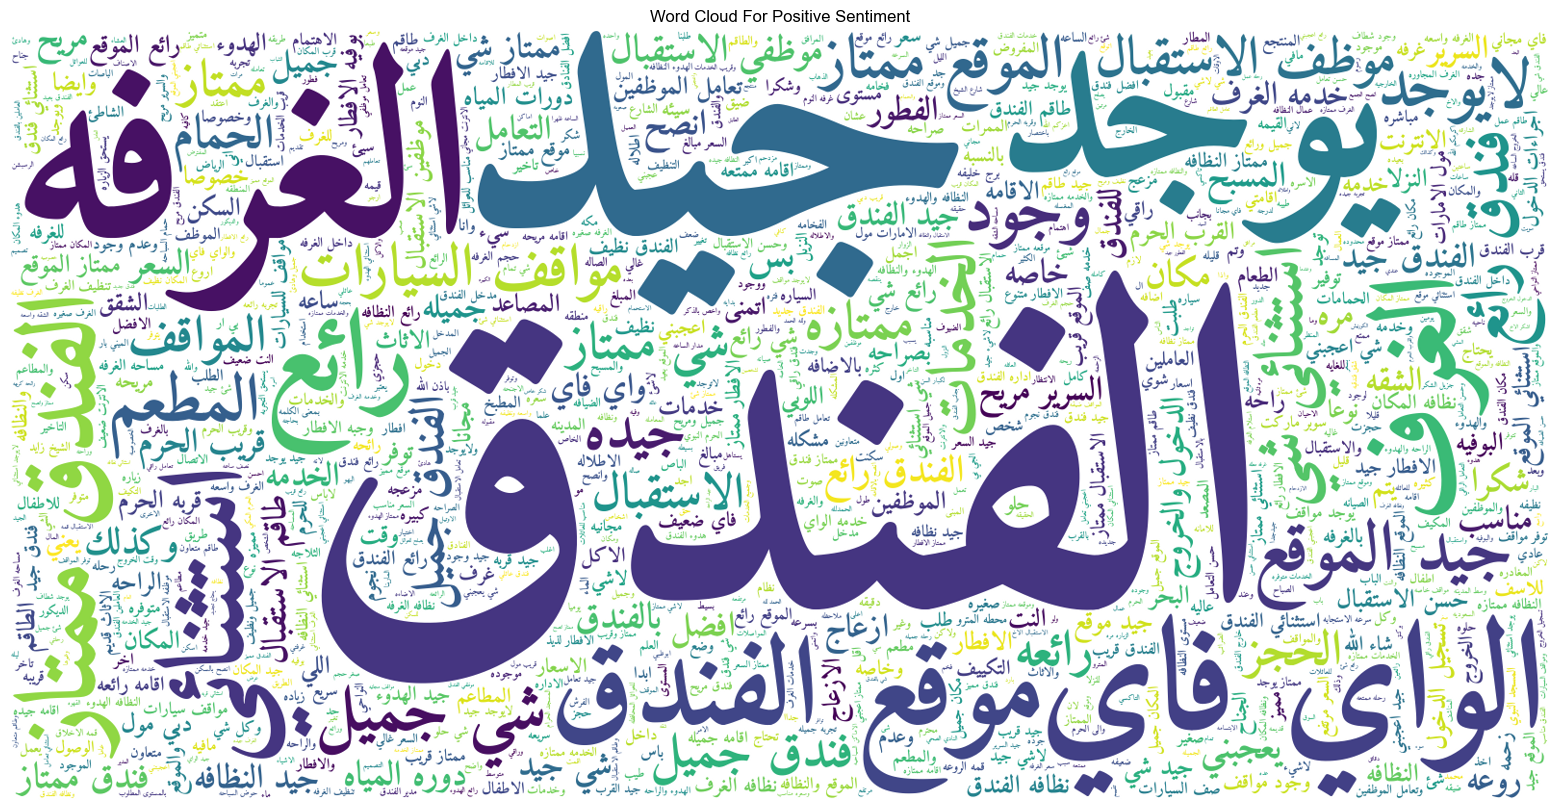

In [36]:
wordcloud(data=Corpus, target='Positive', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

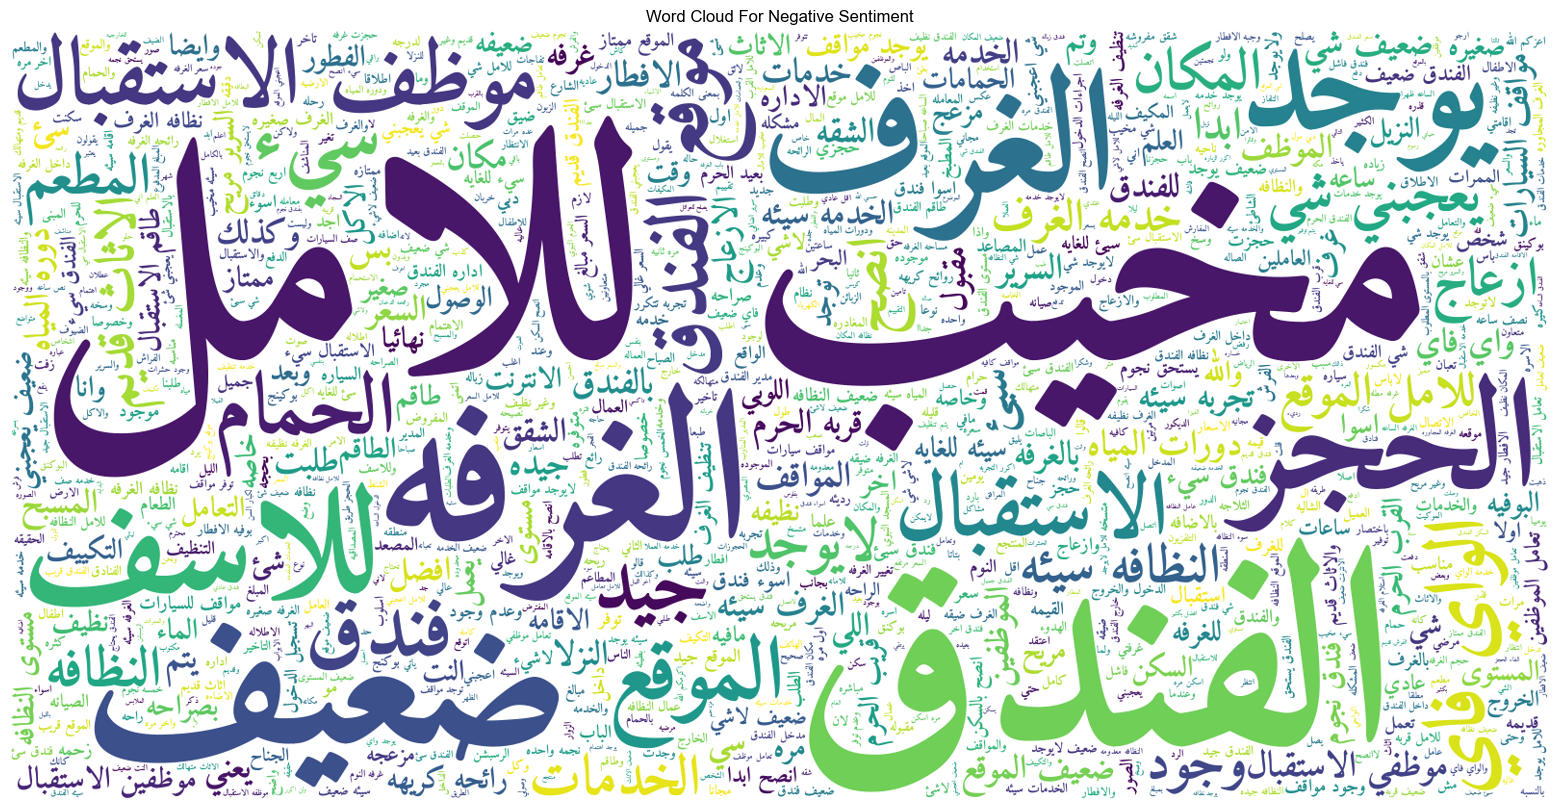

In [37]:
wordcloud(data=Corpus, target='Negative', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

# Most Frequent Words After Review Normalization

In [38]:
MostFrequentWord2 = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF2 = pd.DataFrame(MostFrequentWord2, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF2

Word  Count
1      الفندق  39336
2         جيد  18608
3      الغرفه  17315
4   الاستقبال  16826
5          شي  16521
6       الغرف  15569
7       ممتاز  14883
8        ضعيف  14730
9        فندق  14264
10     الموقع  13796
11       يوجد  12424
12    النظافه  12029
13       سيئه  10015
14       مخيب   9731
15       رائع   9608

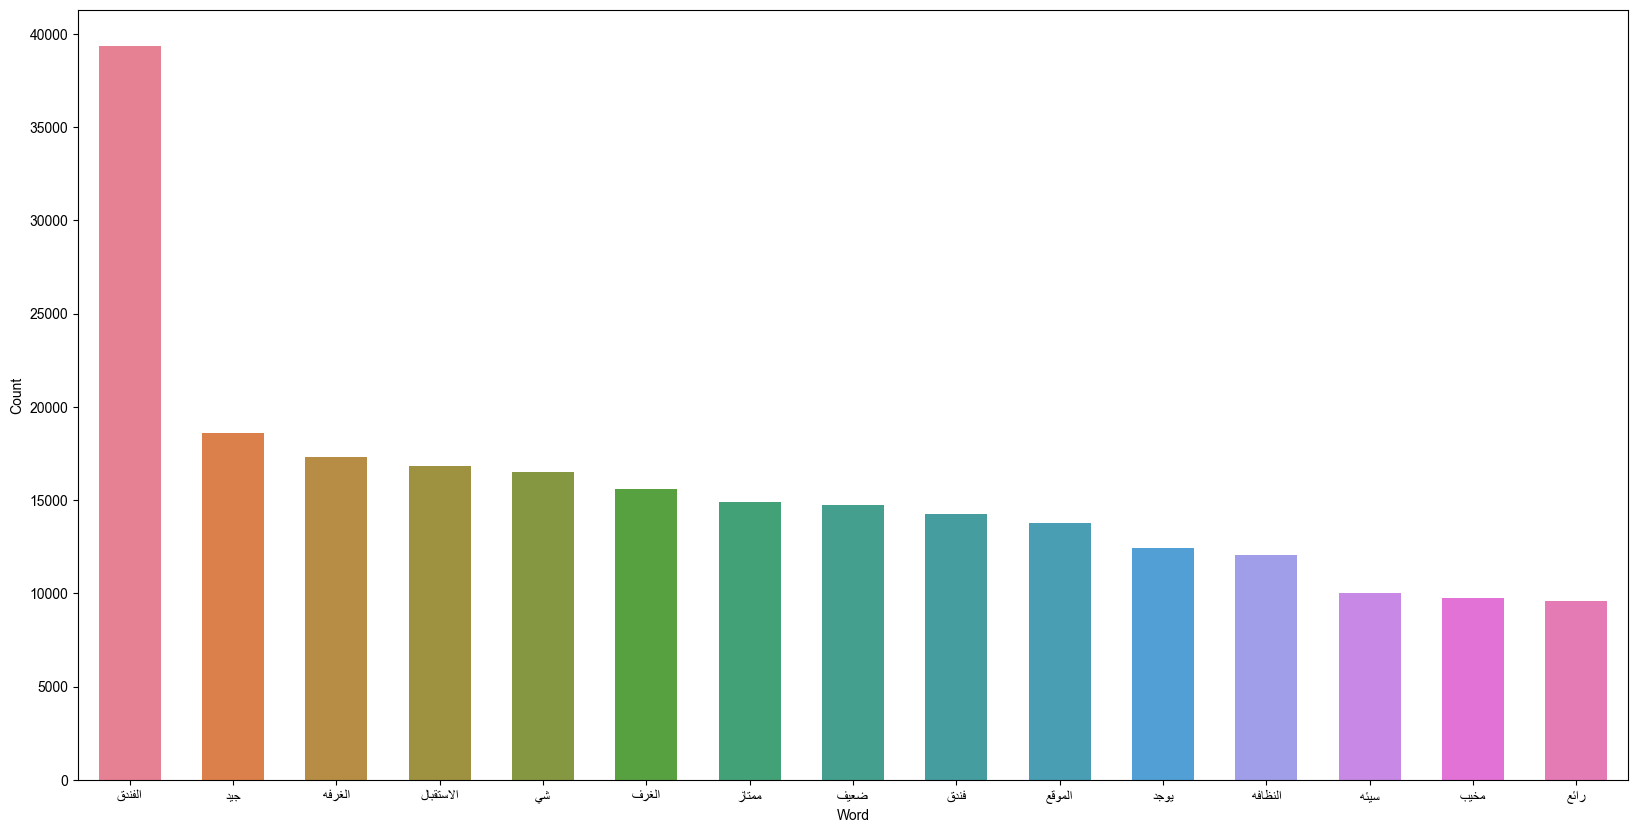

In [39]:
bar_plot(data=MostFrequentWordDF2, text = 'Word', x = 'Word', y='Count')

# Most Frequent Words Of Each Sentiment

**1-Positive**

In [40]:
Positive = Corpus[Corpus['Sentiment'] == 'Positive']

In [41]:
PositiveMostFrequentWord = Counter((Positive['Normalized_Review']).str.split().explode()).most_common(10)
PositiveMostFrequentWordDF = pd.DataFrame(PositiveMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
PositiveMostFrequentWordDF

Word  Count
1      الفندق  17636
2         جيد  15011
3       ممتاز  13412
4        رائع   9149
5          شي   8272
6    استثنائي   7321
7   الاستقبال   7273
8      الموقع   6691
9        فندق   6413
10     الغرفه   6282

**2-Negative**

In [42]:
Negative = Corpus[Corpus['Sentiment'] == 'Negative']

In [43]:
NegativeMostFrequentWord = Counter((Negative['Normalized_Review']).str.split().explode()).most_common(10)
NegativeMostFrequentWordDF = pd.DataFrame(NegativeMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
NegativeMostFrequentWordDF

Word  Count
1      الفندق  21700
2        ضعيف  13678
3      الغرفه  11033
4        مخيب   9728
5       الغرف   9646
6       للامل   9562
7   الاستقبال   9553
8        سيئه   9341
9          شي   8249
10       يوجد   7985

# Part Of Speech Tagging (POS)

In [44]:
word_ = list(UniqueWords)
pos = nltk.pos_tag(word_)
word = []
tag = []

In [45]:
for i in pos:
    word.append(i[0])
    tag.append(i[1])

In [46]:
pos = pd.DataFrame(zip(word, tag), columns=['Word', 'Tag'])
pos.tail()

Word  Tag
119759           يسلب  NNP
119760          الزور  NNP
119761        كفايتها  NNP
119762  جوهرهﻻهتمامهم  NNP
119763          الريش   NN

In [47]:
pos['Tag'].value_counts()

Tag
NNP    119762
JJ          1
NN          1
Name: count, dtype: int64

# Bigrams

In [48]:
Corpus['Bigrams'] = Corpus['Normalized_Review'].apply(lambda x: list(nltk.bigrams(x.split( ))))
Corpus

Review Sentiment  \
0                 جيد. . الانترنت سلكي فقط وبطيئ جداااااا  Positive   
1                      “الهجة”. لاشي. ممنوع دخول الضيوف !  Negative   
2       “انصح به”. نظافة الغرف والخدمه المميزه وموقع ا...  Positive   
3       “رائع”. كل شي حلو وجميل الافطار متنوع. لايوجد ...  Negative   
4       “جيد لكن المطعم سئ”. المعاملة الجيدة. المطعم ب...  Positive   
...                                                   ...       ...   
105287  “المكان خيال”. المكان حده خيال وهدوء وكل شي حلو.   Positive   
105288  “لان اكرر الزياره للفندق للاسف”. الموقع ممتاز ...  Negative   
105289  “من اسوى الفنادق ع الاطلاق”. لا شي سو ديكور ال...  Negative   
105290  “لا انصح بهذا الفندق”. استقبال موظفي الاستقبال...  Negative   
105291  “اتلانتس متعه لاتقاوم”. اعجبني كل شي في الفندق...  Positive   

        NumberOfSentences  Number of Words 1  Number of Charachters 1  \
0                       3                  8                       31   
1                       3                 10                       24   
2                       2                 20                       69   
3                       3                 20                       74   
4                       3                 13                       42   
...                   ...                ...                      ...   
105287                  2                 13                       36   
105288                  3                 32                      151   
105289                  3                 55                      207   
105290                  3                 29                      132   
105291                  3                 18                       63   

                                        Normalized_Review  Number of Words 2  \
0                        جيد الانترنت سلكي وبطيئ جداااااا                  5   
1                            الهجه لاشي ممنوع دخول الضيوف                  5   
2       انصح نظافه الغرف والخدمه المميزه وموقع الفندق ...                 10   
3       رائع شي حلو وجميل الافطار متنوع لايوجد شطاف بد...                 15   
4              جيد المطعم سئ المعامله الجيده المطعم مافيه                  7   
...                                                   ...                ...   
105287       المكان خيال المكان حده خيال وهدوء وكل شي حلو                  9   
105288  اكرر الزياره للفندق للاسف الموقع ممتاز الاستقب...                 23   
105289  اسوى الفنادق الاطلاق شي سو ديكور الوبي الفندق ...                 30   
105290  انصح الفندق استقبال موظفي الاستقبال والعمال مق...                 19   
105291  اتلانتس متعه لاتقاوم اعجبني شي الفندق وسوف اكر...                 11   

        Number of Charachters 2  \
0                            32   
1                            28   
2                            62   
3                            86   
4                            42   
...                         ...   
105287                       44   
105288                      158   
105289                      185   
105290                      132   
105291                       66   

                                                  Bigrams  
0       [(جيد, الانترنت), (الانترنت, سلكي), (سلكي, وبط...  
1       [(الهجه, لاشي), (لاشي, ممنوع), (ممنوع, دخول), ...  
2       [(انصح, نظافه), (نظافه, الغرف), (الغرف, والخدم...  
3       [(رائع, شي), (شي, حلو), (حلو, وجميل), (وجميل, ...  
4       [(جيد, المطعم), (المطعم, سئ), (سئ, المعامله), ...  
...                                                   ...  
105287  [(المكان, خيال), (خيال, المكان), (المكان, حده)...  
105288  [(اكرر, الزياره), (الزياره, للفندق), (للفندق, ...  
105289  [(اسوى, الفنادق), (الفنادق, الاطلاق), (الاطلاق...  
105290  [(انصح, الفندق), (الفندق, استقبال), (استقبال, ...  
105291  [(اتلانتس, متعه), (متعه, لاتقاوم), (لاتقاوم, ا...  

[105292 rows x 9 columns]

# Split The Dataset Into X And y

In [49]:
X, y = Corpus['Normalized_Review'], Corpus['Sentiment']

# Encoding Dependent Variables (Y) Into Integer

In [50]:
y = y.map({'Negative': 0, 'Positive': 1})

# Split The Dataset Into Training And Testing

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22, stratify=y)

# Vectorizer

In [52]:
Vectorizer = TfidfVectorizer()
X_train_vec = Vectorizer.fit_transform(X_train)
X_test_vec = Vectorizer.transform(X_test)

# Word Mapping

In [53]:
Word_mapping = Vectorizer.vocabulary_
Word_mapping_ =pd.DataFrame((list(Word_mapping.items())), columns=['Word', 'Mapping'])
Word_mapping_.tail(5)

Word  Mapping
95922     ابرزه      336
95923    توديعه    36290
95924  ضيقهوجود    47800
95925    وسعدنا    83853
95926      وبذل    80205

# Machine Learning

**1-Naive Bayes**

In [54]:
Algorithm = MultinomialNB(alpha= 1)
model_1 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_1, X_train=X_train_vec, y_train=y_train)

MultinomialNB(alpha=1)

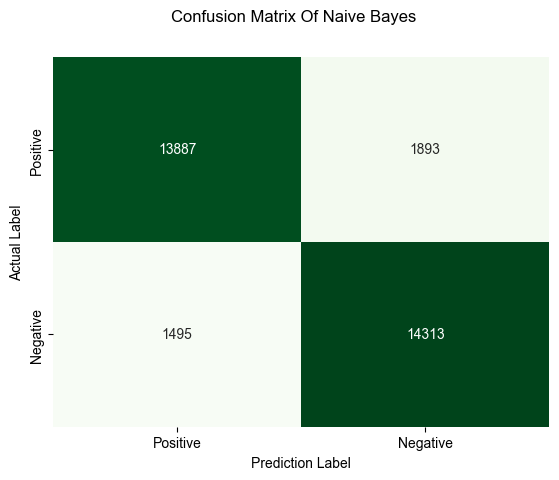

In [55]:
y_predNB = model_1.predict(X_test_vec)
ConfusionMatrixNB = confusion_matrix_(y_test = y_test, y_pred=y_predNB)
confusion_matrix_display(confusion_matrix = ConfusionMatrixNB, name = 'Naive Bayes')

In [56]:
False_PositiveNB, True_PositiveNB, False_NegativeNB, True_NegativeNB = generate_poitive_negative(confusion_matrix=ConfusionMatrixNB)

In [57]:
AccuracyNB = accuracy_score(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)
PrecisionNB= precision_score(True_Positive = True_PositiveNB, False_Positive= False_PositiveNB)

SensitivityNB = sensitivity_score(True_Positive = True_PositiveNB,  False_Negative = False_NegativeNB)
SpecificityNB = specificity_score(True_Negative = True_NegativeNB, False_Positive = False_PositiveNB)

F1ScoreNB = f1_score(True_Positive = True_PositiveNB, False_Negative = False_NegativeNB, False_Positive = False_PositiveNB)
ErrorNB = error_rate(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)

In [58]:
performance_metrics_data_frame(Accuracy = AccuracyNB, Precision = PrecisionNB, Sensitivity = SensitivityNB, Specificity = SpecificityNB, F1Score = F1ScoreNB, Error = ErrorNB)

Values
Accuracy     0.892744
Precision    0.880038
Sensitivity  0.902808
Specificity  0.883191
F1Score      0.891278
Error        0.107256

**2-Logistic Regression**

In [59]:
Algorithm = LogisticRegression()
model_2 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_2, X_train=X_train_vec, y_train=y_train)

LogisticRegression()

In [60]:
y_predLR = model_2.predict(X_test_vec)

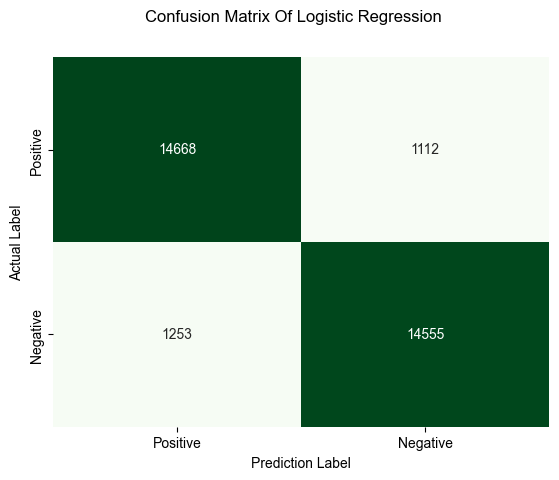

In [61]:
ConfusionMatrixLR = confusion_matrix_(y_test= y_test, y_pred=y_predLR)
confusion_matrix_display(confusion_matrix = ConfusionMatrixLR, name = 'Logistic Regression')

In [62]:
False_PositiveLR, True_PositiveLR, False_NegativeLR, True_NegativeLR = generate_poitive_negative(confusion_matrix=ConfusionMatrixLR)

In [63]:
AccuracyLR = accuracy_score(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)
PrecisionLR= precision_score(True_Positive = True_PositiveLR, False_Positive= False_PositiveLR)

SensitivityLR = sensitivity_score(True_Positive = True_PositiveLR,  False_Negative = False_NegativeLR)
SpecificityLR = specificity_score(True_Negative = True_NegativeLR, False_Positive = False_PositiveLR)

F1ScoreLR = f1_score(True_Positive = True_PositiveLR, False_Negative = False_NegativeLR, False_Positive = False_PositiveLR)
ErrorLR = error_rate(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)

In [64]:
performance_metrics_data_frame(Accuracy = AccuracyLR, Precision = PrecisionLR, Sensitivity = SensitivityLR, Specificity = SpecificityLR, F1Score = F1ScoreLR, Error = ErrorLR)

Values
Accuracy     0.925130
Precision    0.929531
Sensitivity  0.921299
Specificity  0.929023
F1Score      0.925397
Error        0.074870

**3-Decision Tree**

In [65]:
Algorithm = DecisionTreeClassifier(criterion='gini')
model_3 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_3, X_train=X_train_vec, y_train=y_train)

DecisionTreeClassifier()

In [66]:
y_predDT = model_3.predict(X_test_vec)

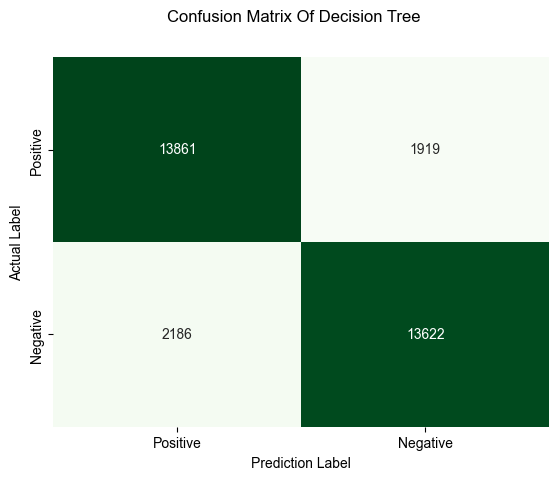

In [67]:
ConfusionMatrixDT = confusion_matrix_(y_test = y_test, y_pred=y_predDT)
confusion_matrix_display(confusion_matrix = ConfusionMatrixDT, name = 'Decision Tree')
False_PositiveDT, True_PositiveDT, False_NegativeDT, True_NegativeDT = generate_poitive_negative(confusion_matrix=ConfusionMatrixDT)

In [68]:
AccuracyDT = accuracy_score(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)
PrecisionDT= precision_score(True_Positive = True_PositiveDT, False_Positive =False_PositiveDT)

SensitivityDT = sensitivity_score(True_Positive = True_PositiveDT,  False_Negative = False_NegativeDT)
SpecificityDT = specificity_score(True_Negative = True_NegativeDT, False_Positive = False_PositiveDT)

F1ScoreDT = f1_score(True_Positive = True_PositiveDT, False_Negative = False_NegativeDT, False_Positive = False_PositiveDT)
ErrorDT = error_rate(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)

In [69]:
performance_metrics_data_frame(Accuracy = AccuracyDT, Precision = PrecisionDT, Sensitivity = SensitivityDT, Specificity = SpecificityDT, F1Score = F1ScoreDT, Error = ErrorDT)

Values
Accuracy     0.870046
Precision    0.878390
Sensitivity  0.863775
Specificity  0.876520
F1Score      0.871021
Error        0.129954

**4-K Nearest Neighbors**

In [70]:
Algorithm =KNeighborsClassifier(metric='cosine', n_neighbors=5)
model_4 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_4, X_train=X_train_vec, y_train=y_train)

KNeighborsClassifier(metric='cosine')

In [71]:
y_predKNN = model_4.predict(X_test_vec)

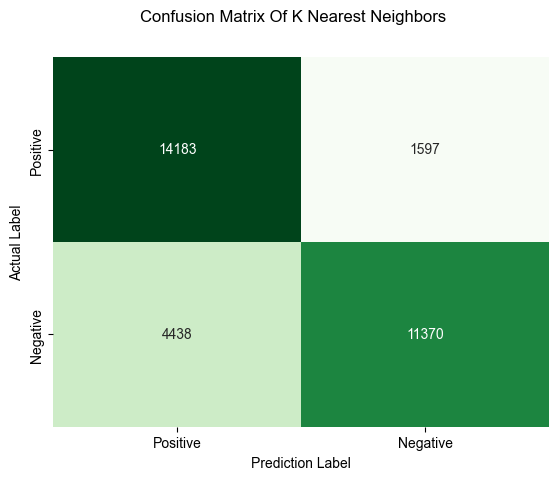

In [72]:
ConfusionMatrixKNN = confusion_matrix_(y_pred= y_predKNN, y_test=y_test)
confusion_matrix_display(confusion_matrix = ConfusionMatrixKNN, name = 'K Nearest Neighbors')
False_PositiveKNN, True_PositiveKNN, False_NegativeKNN, True_NegativeKNN = generate_poitive_negative(confusion_matrix=ConfusionMatrixKNN)

In [73]:
AccuracyKNN = accuracy_score(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)
PrecisionKNN= precision_score(True_Positive = True_PositiveKNN, False_Positive =False_PositiveKNN)

SensitivityKNN = sensitivity_score(True_Positive = True_PositiveKNN,  False_Negative = False_NegativeKNN)
SpecificityKNN = specificity_score(True_Negative = True_NegativeKNN, False_Positive = False_PositiveKNN)

F1ScoreKNN = f1_score(True_Positive = True_PositiveKNN, False_Negative = False_NegativeKNN, False_Positive = False_PositiveKNN)
ErrorKNN = error_rate(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)

In [74]:
performance_metrics_data_frame(Accuracy = AccuracyKNN, Precision = PrecisionKNN, Sensitivity = SensitivityKNN, Specificity = SpecificityKNN, F1Score = F1ScoreKNN, Error = ErrorKNN)

Values
Accuracy     0.808946
Precision    0.898796
Sensitivity  0.761667
Specificity  0.876841
F1Score      0.824569
Error        0.191054

**5-Random Forest**

In [75]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=300, random_state=22)
model_5 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_5, X_train=X_train_vec, y_train=y_train)

RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=22)

In [76]:
y_predRF = model_5.predict(X_test_vec)

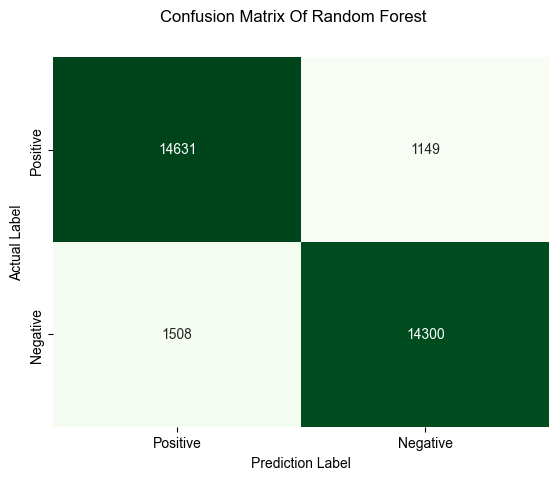

In [77]:
ConfusionMatrixRF = confusion_matrix_(y_test=y_test, y_pred=y_predRF)
confusion_matrix_display(confusion_matrix = ConfusionMatrixRF, name = 'Random Forest')
False_PositiveRF, True_PositiveRF, False_NegativeRF, True_NegativeRF = generate_poitive_negative(confusion_matrix=ConfusionMatrixRF)

In [78]:
AccuracyRF = accuracy_score(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)
PrecisionRF= precision_score(True_Positive = True_PositiveRF, False_Positive =False_PositiveRF)

SensitivityRF = sensitivity_score(True_Positive = True_PositiveRF,  False_Negative = False_NegativeRF)
SpecificityRF = specificity_score(True_Negative = True_NegativeRF, False_Positive = False_PositiveRF)

F1ScoreRF = f1_score(True_Positive = True_PositiveRF, False_Negative = False_NegativeRF, False_Positive = False_PositiveRF)
ErrorRF = error_rate(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)

In [79]:
performance_metrics_data_frame(Accuracy = AccuracyRF, Precision = PrecisionRF, Sensitivity = SensitivityRF, Specificity = SpecificityRF, F1Score = F1ScoreRF, Error = ErrorRF)

Values
Accuracy     0.915886
Precision    0.927186
Sensitivity  0.906562
Specificity  0.925626
F1Score      0.916758
Error        0.084114

**6-SGD Classifier**

In [80]:
Algorithm = SGDClassifier(loss='hinge')
model_6 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_6, X_train=X_train_vec, y_train=y_train)

SGDClassifier()

In [81]:
y_predSGD = model_6.predict(X_test_vec)

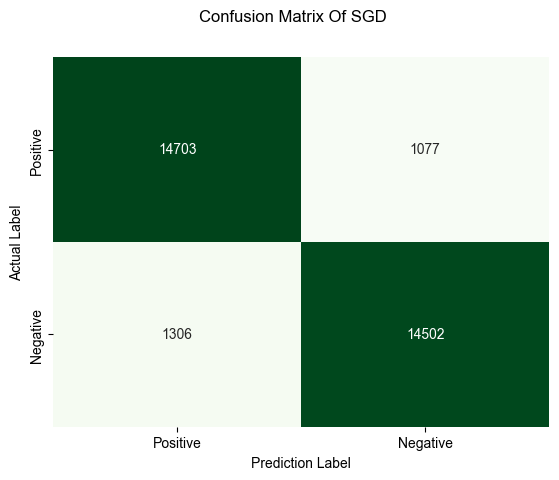

In [82]:
ConfusionMatrixSGD = confusion_matrix_(y_test=y_test, y_pred=y_predSGD)
confusion_matrix_display(confusion_matrix = ConfusionMatrixSGD, name = 'SGD')
False_PositiveSGD, True_PositiveSGD, False_NegativeSGD, True_NegativeSGD = generate_poitive_negative(confusion_matrix=ConfusionMatrixSGD)

In [83]:
AccuracySGD = accuracy_score(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)
PrecisionSGD= precision_score(True_Positive = True_PositiveSGD, False_Positive =False_PositiveSGD)

SensitivitySGD = sensitivity_score(True_Positive = True_PositiveSGD,  False_Negative = False_NegativeSGD)
SpecificitySGD = specificity_score(True_Negative = True_NegativeSGD, False_Positive = False_PositiveSGD)

F1ScoreSGD = f1_score(True_Positive = True_PositiveSGD, False_Negative = False_NegativeSGD, False_Positive = False_PositiveSGD)
ErrorSGD = error_rate(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)

In [84]:
performance_metrics_data_frame(Accuracy = AccuracySGD, Precision = PrecisionSGD, Sensitivity = SensitivitySGD, Specificity = SpecificitySGD, F1Score = F1ScoreSGD, Error = ErrorSGD)

Values
Accuracy     0.924560
Precision    0.931749
Sensitivity  0.918421
Specificity  0.930868
F1Score      0.925037
Error        0.075440

**7-XGBOOST Classifier**

In [85]:
Algorithm = XGBClassifier();
model_7 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_7, X_train=X_train_vec, y_train=y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
y_predXGB = model_7.predict(X_test_vec)

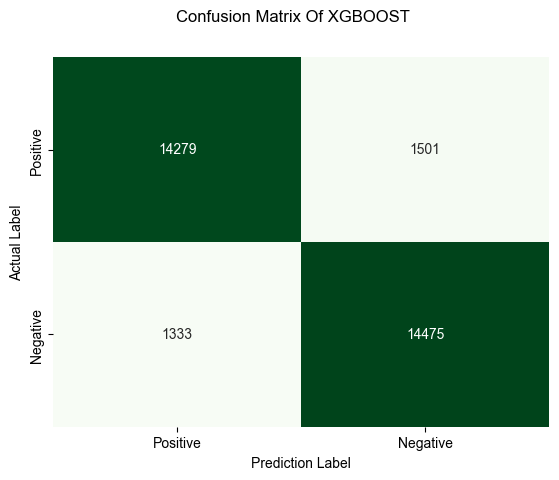

In [87]:
ConfusionMatrixXGB= confusion_matrix_(y_test=y_test, y_pred=y_predXGB)
confusion_matrix_display(confusion_matrix = ConfusionMatrixXGB, name = 'XGBOOST')
False_PositiveXGB, True_PositiveXGB, False_NegativeXGB, True_NegativeXGB = generate_poitive_negative(confusion_matrix=ConfusionMatrixXGB)

In [88]:
AccuracyXGB = accuracy_score(True_Positive = True_PositiveXGB, True_Negative = True_NegativeXGB, False_Positive =False_PositiveXGB, False_Negative = False_NegativeXGB)
PrecisionXGB= precision_score(True_Positive = True_PositiveXGB, False_Positive =False_PositiveXGB)

SensitivityXGB = sensitivity_score(True_Positive = True_PositiveXGB,  False_Negative = False_NegativeXGB)
SpecificityXGB = specificity_score(True_Negative = True_NegativeXGB, False_Positive = False_PositiveXGB)

F1ScoreXGB = f1_score(True_Positive = True_PositiveXGB, False_Negative = False_NegativeXGB, False_Positive = False_PositiveXGB)
ErrorXGB = error_rate(True_Positive = True_PositiveXGB, True_Negative = True_NegativeXGB, False_Positive =False_PositiveXGB, False_Negative = False_NegativeXGB)

In [89]:
performance_metrics_data_frame(Accuracy = AccuracyXGB, Precision = PrecisionXGB, Sensitivity = SensitivityXGB, Specificity = SpecificityXGB, F1Score = F1ScoreXGB, Error = ErrorXGB)

Values
Accuracy     0.910282
Precision    0.904880
Sensitivity  0.914617
Specificity  0.906047
F1Score      0.909722
Error        0.089718

# Deep Learning

**1.Preprocessing**

In [90]:
tokenizer, vocab_size, max_length, encoded_X_train, encoded_X_test, word_index = deeplearning_preprcosesing_(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test , truncating='pre', padding='pre')

In [91]:
print('The Vocab Size Is :',vocab_size)
print('')
print('The Max Length Is :', max_length)

The Vocab Size Is : 95947

The Max Length Is : 391


**2.Word Index**

In [92]:
Word_Index = word_index
Word_Index_ =pd.DataFrame(((list(Word_Index.items()))), columns=['Word', 'Index'])
Word_Index_.tail()

Word  Index
95942     ابرزه  95943
95943    توديعه  95944
95944  ضيقهوجود  95945
95945    وسعدنا  95946
95946      وبذل  95947

**3.Train Word2Vector**

In [93]:
word_2_vec_(data = Data[0], vector_size = 100, sg = 1, name = "Arabic Word Vector")

**4.Generate Word Vector**

In [94]:
word_vector = word_vector_(model_path = 'Arabic Word Vector.txt', vocab_size = vocab_size , tokenizer = tokenizer)

# Deep Learing Models

**8-LSTM**

Epoch 1/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 475s 206ms/step - accuracy: 0.8037 - loss: 0.3970 - val_accuracy: 0.9260 - val_loss: 0.2014 - learning_rate: 1.0000e-04
Epoch 2/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 470s 204ms/step - accuracy: 0.9368 - loss: 0.1830 - val_accuracy: 0.9304 - val_loss: 0.1977 - learning_rate: 1.0000e-04
Epoch 3/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 471s 204ms/step - accuracy: 0.9521 - loss: 0.1463 - val_accuracy: 0.9270 - val_loss: 0.1982 - learning_rate: 1.0000e-04
Epoch 4/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 466s 202ms/step - accuracy: 0.9630 - loss: 0.1174 - val_accuracy: 0.9247 - val_loss: 0.2126 - learning_rate: 1.0000e-04
Epoch 5/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 465s 202ms/step - accuracy: 0.9686 - loss: 0.0999 - val_accuracy: 0.9200 - val_loss: 0.2364 - learning_rate: 1.0000e-04
Epoch 6/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 476s 207ms/step - accuracy: 0.9732 - loss: 0.0855 - val_accuracy: 0.9165 - val_loss: 0.2622 - learning_rate: 1.0000e-04
Epoch 7/10
2304/2304 ━━━━━━━

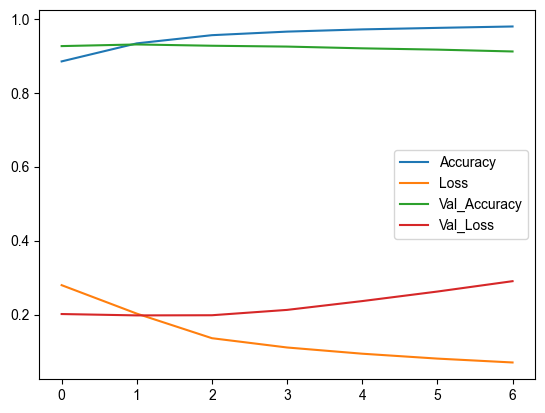

In [95]:
model_8 =lstm_(vocab_size = vocab_size +1 , embedding_dim = 100, max_length = max_length, units1 = 64,  units2 = 32, embeddings_matrix = word_vector)
model_compile(model=model_8)
history = model_fit(model=model_8, X_train=encoded_X_train, y_train=y_train, epochs=10, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)  

**9-GRU**

Epoch 1/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 497s 215ms/step - accuracy: 0.8093 - loss: 0.3879 - val_accuracy: 0.9227 - val_loss: 0.2091 - learning_rate: 1.0000e-04
Epoch 2/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 488s 212ms/step - accuracy: 0.9341 - loss: 0.1802 - val_accuracy: 0.9278 - val_loss: 0.1980 - learning_rate: 1.0000e-04
Epoch 3/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 490s 213ms/step - accuracy: 0.9556 - loss: 0.1327 - val_accuracy: 0.9263 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 4/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 493s 214ms/step - accuracy: 0.9658 - loss: 0.1047 - val_accuracy: 0.9226 - val_loss: 0.2273 - learning_rate: 1.0000e-04
Epoch 5/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 488s 212ms/step - accuracy: 0.9726 - loss: 0.0851 - val_accuracy: 0.9168 - val_loss: 0.2548 - learning_rate: 1.0000e-04
Epoch 6/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 485s 211ms/step - accuracy: 0.9776 - loss: 0.0716 - val_accuracy: 0.9116 - val_loss: 0.2866 - learning_rate: 1.0000e-04
Epoch 7/10
2304/2304 ━━━━━━━

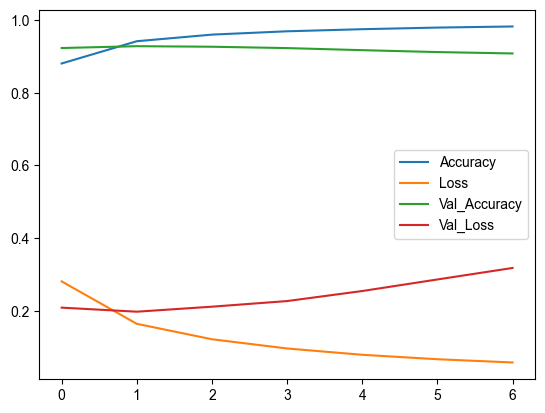

In [96]:
model_9 = gru_(vocab_size = vocab_size + 1, embedding_dim = 100, max_length = max_length, units1 = 64,  units2 = 32,  embeddings_matrix = word_vector)
model_compile(model=model_9)
history = model_fit(model=model_9, X_train=encoded_X_train, y_train=y_train, epochs=10, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)

**10-Bidirectional LSTM**

Epoch 1/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 655s 283ms/step - accuracy: 0.8122 - loss: 0.3955 - val_accuracy: 0.9233 - val_loss: 0.2261 - learning_rate: 1.0000e-04
Epoch 2/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 669s 290ms/step - accuracy: 0.9326 - loss: 0.1969 - val_accuracy: 0.9274 - val_loss: 0.2020 - learning_rate: 1.0000e-04
Epoch 3/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 645s 280ms/step - accuracy: 0.9500 - loss: 0.1498 - val_accuracy: 0.9200 - val_loss: 0.2227 - learning_rate: 1.0000e-04
Epoch 4/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 641s 278ms/step - accuracy: 0.9623 - loss: 0.1225 - val_accuracy: 0.9180 - val_loss: 0.2388 - learning_rate: 1.0000e-04
Epoch 5/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 645s 280ms/step - accuracy: 0.9704 - loss: 0.0994 - val_accuracy: 0.9158 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 6/10
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 686s 298ms/step - accuracy: 0.9766 - loss: 0.0829 - val_accuracy: 0.9096 - val_loss: 0.2939 - learning_rate: 1.0000e-04
Epoch 7/10
2304/2304 ━━━━━━━

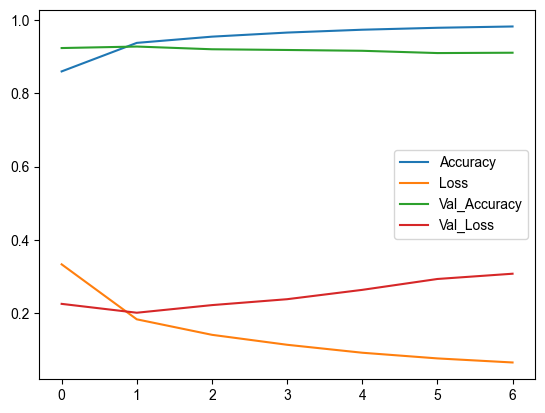

In [99]:
model_10 = bidirectional_lstm(vocab_size = vocab_size + 1, embedding_dim = 100, max_length = max_length, units1 = 64,  units2 = 32, embeddings_matrix = word_vector)
model_compile(model=model_10)
history = model_fit(model=model_10, X_train=encoded_X_train, y_train=y_train, epochs=10, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)

# Model Inference

**1-Naive Bayes**

In [102]:
machine_learning_inference(model=model_1,vectorizer=Vectorizer, text = reviews, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Negative

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Positive

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**2-Logistic Regression**

In [103]:
machine_learning_inference(model=model_2,vectorizer=Vectorizer, text = reviews, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Positive

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Negative

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**3-Decision Tree**

In [104]:
machine_learning_inference(model=model_3,vectorizer=Vectorizer, text = reviews, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Positive

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Negative

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**4-K Nearest Neighbors**

In [105]:
machine_learning_inference(model=model_4,vectorizer=Vectorizer, text = reviews, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Positive

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Positive

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**5-Random Forest**

In [106]:
machine_learning_inference(model=model_5,vectorizer=Vectorizer, text = reviews, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Positive

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Negative

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**6-SGD Classifier**

In [107]:
machine_learning_inference(model=model_6,vectorizer=Vectorizer, text = reviews, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Negative

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Negative

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**7-XGBOOST**

In [108]:
machine_learning_inference(model = model_7, vectorizer=Vectorizer, text = reviews, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Negative

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Negative

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Negative

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**8-LSTM**

In [109]:
deep_learning_inference(model = model_8, text = reviews , tokenizer = tokenizer, max_length = max_length, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Positive

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Negative

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**9-Bidirectional LSTM**

In [110]:
deep_learning_inference(model = model_9, text = reviews , tokenizer = tokenizer, max_length = max_length, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Positive

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Negative

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



**10-GRU**

In [111]:
deep_learning_inference(model = model_10, text = reviews , tokenizer = tokenizer, max_length = max_length, text_normalization = text_normalization)

Review: تجربتي الفندق سيئه للغايه الغرفه نظيفه والموظفون متعاونين الاطلاق
Sentiment: Negative

Review: الخدمه الفندق مخيبه للامال انتظرت ساعه لتلقي الطعام المطعم
Sentiment: Negative

Review: الاسره الغرفه مريحه جد
Sentiment: Positive

Review: الفندق يستحق الاسعار المرتفعه يفرضها الغرف مريحه توقعت
Sentiment: Negative

Review: اقامتي الفندق رائعه الغرفه نظيفه ومريحه والموظفون ودودين جد
Sentiment: Positive

Review: الخدمه الفندق ممتازه الموظفون دائم مستعدين لمساعدتي احتاجه
Sentiment: Positive

Review: الفندق يقع موقع مثالي بالقرب الشاطئ والاسواق مرمى البصر
Sentiment: Positive

Review: الفندق جو مريح مكان مثالي للاسترخاء السفر
Sentiment: Positive

Review: استمتعت بتناول الطعام المطعم الاطباق لذيذه ومتنوعه
Sentiment: Positive

Review: المرافق الفندق قديمه وغير نظيفه ارى يحتاج تجديدات عاجله
Sentiment: Negative



# Transformers

In [112]:
sentiment_analysis_transformers(reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ